In [20]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
data = pd.read_csv("bank_data.csv")

In [3]:
print("Unique zipCodeOri values: ",data.zipcodeOri.nunique())
print("Unique zipMerchant values: ",data.zipMerchant.nunique())
data_reduced = data.drop(['zipcodeOri','zipMerchant'],axis=1)

Unique zipCodeOri values:  1
Unique zipMerchant values:  1


In [4]:
data_reduced.columns

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')

In [5]:
# turning object columns type to categorical for easing the transformation process
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
data_reduced.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [6]:
X = data_reduced.drop(['fraud'],axis=1)
y = data['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


In [7]:
y[y==1].count()

7200

### Smote

In [8]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
print(y_res.value_counts())

fraud
0        587443
1        587443
dtype: int64


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [10]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### k-neighbour classification

C:\Anaconda\envs\DAB300\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


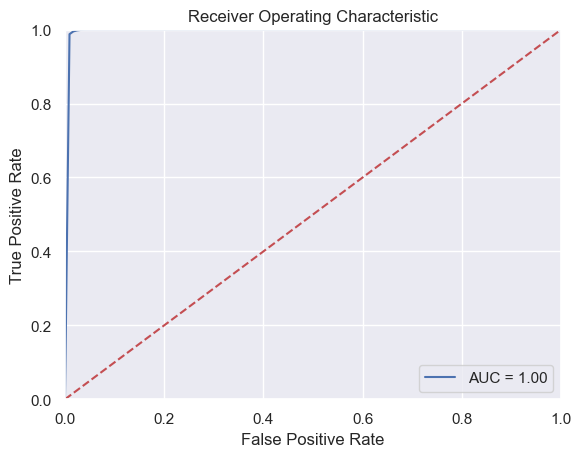

In [11]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)


print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])

### Random forest

C:\Anaconda\envs\DAB300\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  2.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    9.4s finished


Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    176233
           1       0.97      0.99      0.98    176233

    accuracy                           0.98    352466
   macro avg       0.98      0.98      0.98    352466
weighted avg       0.98      0.98      0.98    352466

Confusion Matrix of Random Forest Classifier: 
 [[170106   6127]
 [  1079 175154]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.5s finished


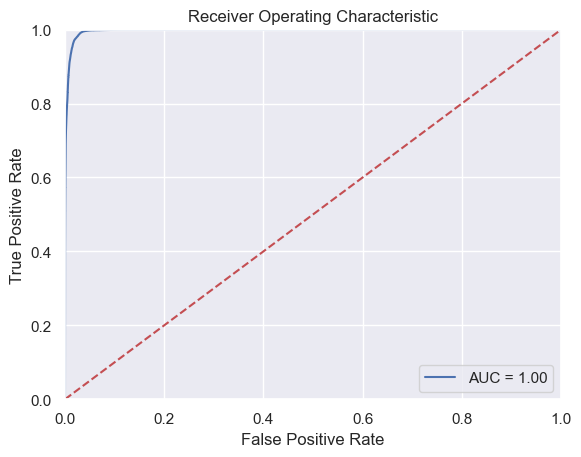

In [12]:
rf_clf = RandomForestClassifier(n_estimators=100,max_depth=8,random_state=42,
                                verbose=1,class_weight="balanced")

rf_clf.fit(X_train,y_train)
y_pred = rf_clf.predict(X_test)

print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, rf_clf.predict_proba(X_test)[:,1])

### XG-boost Classifier

Classification Report for XGBoost: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of XGBoost: 
 [[174047   2186]
 [   706 175527]]


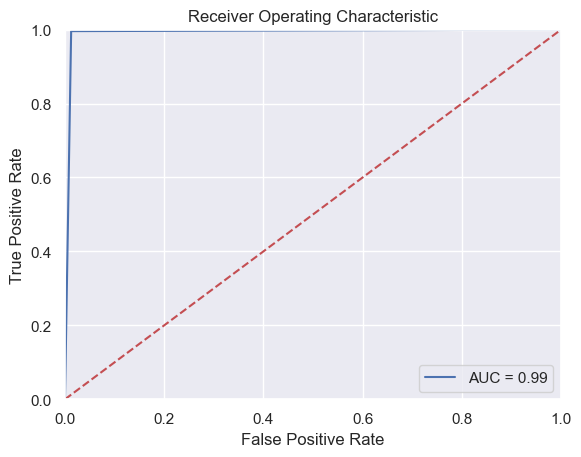

In [13]:
XGBoost_CLF = xgb.XGBClassifier(max_depth=6, learning_rate=0.05, n_estimators=400, 
                                objective="binary:hinge", booster='gbtree', 
                                n_jobs=-1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, 
                                subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                                scale_pos_weight=1, base_score=0.5, random_state=42, verbosity=0)

XGBoost_CLF.fit(X_train,y_train)

y_pred = XGBoost_CLF.predict(X_test)

print("Classification Report for XGBoost: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of XGBoost: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, XGBoost_CLF.predict_proba(X_test)[:,1])

### Decision Tree Classification

Classification Report for Decision tree: 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    176233
           1       0.99      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of Decision tree: 
 [[174669   1564]
 [   751 175482]]


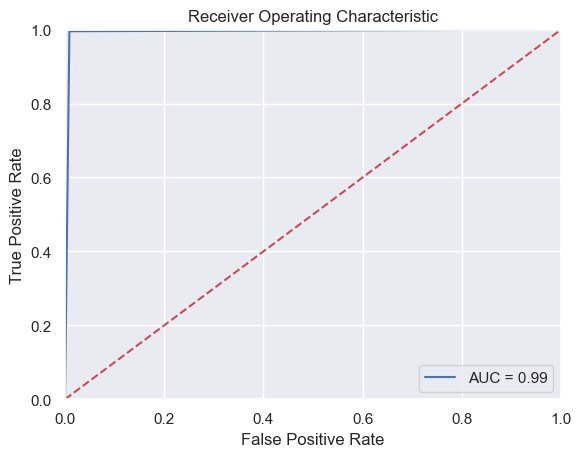

In [19]:
DTC = DecisionTreeClassifier(random_state=94)
DTC.fit(X_train, y_train)
y_pred = DTC.predict(X_test)

print("Classification Report for Decision tree: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Decision tree: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, DTC.predict_proba(X_test)[:,1])

### Logistic Regression

C:\Anaconda\envs\DAB300\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification Report for Logistic Regression: 
               precision    recall  f1-score   support

           0       0.90      0.95      0.92    176233
           1       0.95      0.89      0.92    176233

    accuracy                           0.92    352466
   macro avg       0.92      0.92      0.92    352466
weighted avg       0.92      0.92      0.92    352466

Confusion Matrix of Logistic Regression: 
 [[167539   8694]
 [ 19059 157174]]


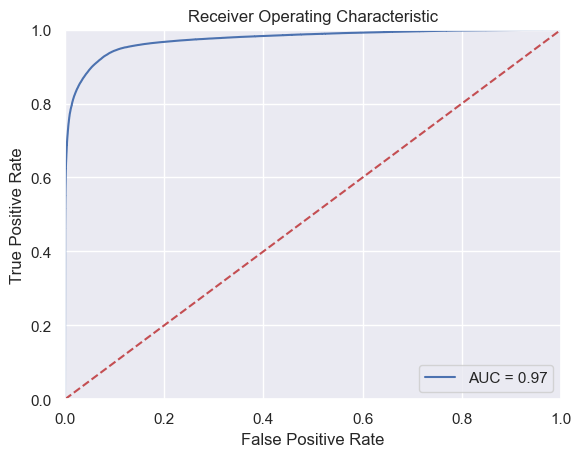

In [21]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
y_pred = LRmodel.predict(X_test)

print("Classification Report for Logistic Regression: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Logistic Regression: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, LRmodel.predict_proba(X_test)[:,1])